In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12


In [2]:
def testscore(predtmp,oritmp):
    score=1
    pred=np.ravel(predtmp)
    ori=np.ravel(oritmp)
    n=0
    for i in range(len(pred)):
        if ori[i]!=0:
            n=n+1
    #print(n)
    for i in range(len(pred)):
        if ori[i]!=0:
            score=score-1/n*abs(pred[i]-ori[i])/abs(ori[i])/2
            #print(abs(pred[i]-ori[i])/abs(ori[i]))
    print('score:')
    print(score)
    return score

In [3]:

file_path = os.path.join('D:\\', 'hotaidata','sr_C4_12')
x=[]
y=[]
vx=[]
vy=[]
isvalid=[]
xtmp=[]
ytmp=[]
vxtmp=[]
vytmp=[]
isvalidtmp=[]
for root,dirs,files in os.walk(file_path):
    #print(root)
    
    for dir in dirs:
        #print(os.path.join(root,file))

            with open(os.path.join(root,dir,'B00001.dat'), 'r') as f:  
                lines = f.readlines()
                for line in lines[3:]: 
                    num=line.split()
                    xtmp.append(float(num[0]))
                    ytmp.append(float(num[1]))
                    vxtmp.append(float(num[2]))
                    vytmp.append(float(num[3]))
                    isvalidtmp.append(float(num[4]))

            x.append(np.array(xtmp).reshape(25,25))
            y.append(np.array(ytmp).reshape(25,25))
            vx.append(np.array(vxtmp).reshape(25,25))
            vy.append(np.array(vytmp).reshape(25,25))
            isvalid.append(np.array(isvalidtmp).reshape(25,25))
            xtmp=[]
            ytmp=[]
            vxtmp=[]
            vytmp=[]
            isvalidtmp=[]
#
x=np.array(x)
y=np.array(y)
vx=np.array(vx)
vy=np.array(vy)
isvalid=np.array(isvalid)

x=x.T
y=y.T
vx=vx.T
vy=vy.T
#print(x[0,:,:])
t=np.linspace(0,0.0008,40)
t_train=np.linspace(0.0,0.0008,3*len(t)-2)
dt=0.00002


In [4]:

spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T
'''
print('spatial_grid')
print(spatial_grid.shape)
print(spatial_grid)
'''

n=25

u=np.zeros((n,n,121, 2))
tmp=np.zeros((n,n,40, 2))
u[:, :, :, 0] = vx
u[:, :, :, 1] = vy
u_train=np.zeros((n,n,40, 2))
save=np.zeros((n,n,40, 2))
u_train=u[:,:,80:120,:]
save=u[:,:,80:120,:]


In [5]:
u_dot = ps.FiniteDifference(axis=2)._differentiate(u_train, dt)
tmp[:,:,0]=u_train[:,:,0]
for i in range(len(t)-1):
    tmp[:,:,i+1]=tmp[:,:,i]+u_dot[:,:,i]*dt
testscore(tmp,u_train)
tmp=u_train+u_dot*dt
tmp[:,:,1:]=tmp[:,:,:len(t)-1]
testscore(tmp,u_train)

score:
-3.5798525560826437
score:
-0.8355080071035742


-0.8355080071035742

In [13]:
op=np.zeros(len(t))
op=u_train[10,10,:,0]
op_train=np.zeros(len(t_train))
for i in range(len(t)-1):
    op_train[i*3]=op[i]
    op_train[i*3+1]=(op[i]*2+op[i+1])/3
    op_train[i*3+2]=(op[i]+op[i+1]*2)/3
op_train[-1]=op[-1]

<function matplotlib.pyplot.show(close=None, block=None)>

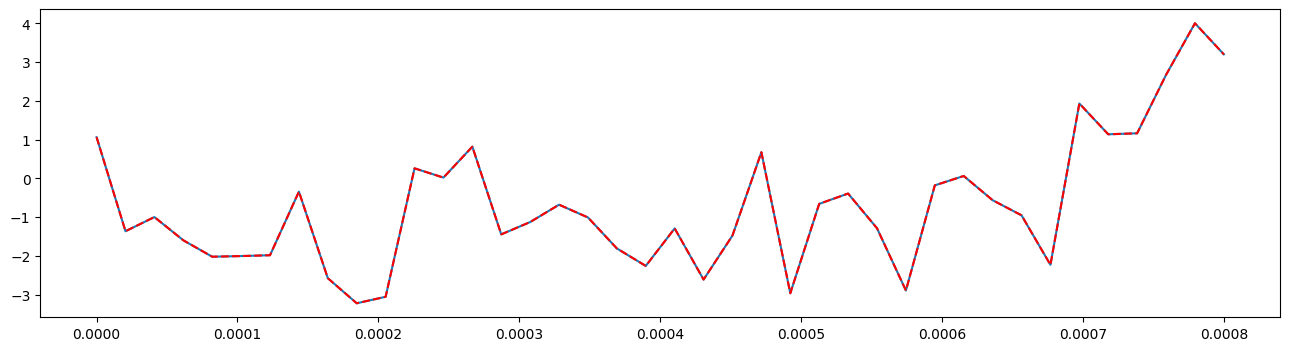

In [14]:
plt.figure(figsize=(16, 4))
plt.plot(t,op)
plt.plot(t_train,op_train,'r--')
plt.show

score:
-0.7900947407128605
score:
0.7106977920885262
[-191062.9384275  -51502.8757825   -5833.76288    -25568.4486
  -10177.633195      953.917575    41533.7336075  -14809.9097475
  -71981.972785   -11981.5969575   87028.498385    76858.218625
   13970.2210675  -36617.7622725  -48623.89168     19142.7214825
    2964.3861525  -28212.32278    -31253.4132      12909.5891475
   -8784.6749275   -4574.5228375   82127.87484    -37233.077615
  -33312.89242     64302.4811325  -15732.748185   -62537.9093125
   27651.3286975   73859.0497275   -9557.9135275  -25361.7863275
  -41681.4024375   72102.533       84177.856135   -19210.2467525
   38328.7072975   70948.715565    13232.0316525  -93367.5845525]


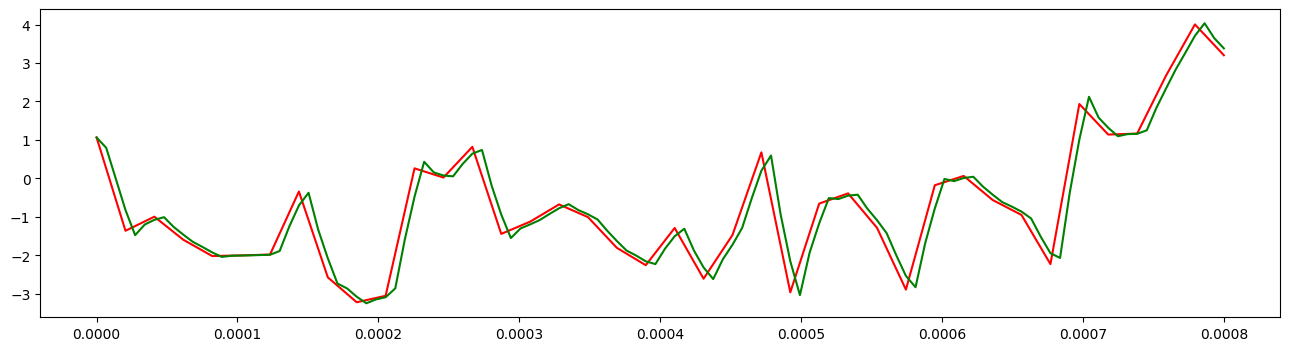

In [15]:

op_dot=np.zeros(len(t))
op_dot = ps.FiniteDifference(axis=0)._differentiate(op, dt)
op_train_dot=np.zeros(len(t_train))
op_train_dot = ps.FiniteDifference(axis=0)._differentiate(op_train, dt)
tmpop=np.zeros(len(t))
tmpop[0]=op[0]
tmpop[1:]=op[:len(t)-1]+op_dot[:len(t)-1]*dt
tmp_op_train=np.zeros(len(t_train))
tmp_op_train[0]=op_train[0]
tmp_op_train[1:]=op_train[:len(t_train)-1]+op_train_dot[:len(t_train)-1]*dt/3
plt.figure(figsize=(16, 4))
plt.plot(t,op,color='r')
#plt.plot(t,tmpop,color='b')
plt.plot(t_train,tmp_op_train,color='g')
plt.show
testscore(tmpop,op)
testscore(tmp_op_train,op_train)
compare=np.zeros((len(t),2))
compare[:,0]=op
compare[:,1]=tmpop
'-0.79'
print(op_dot)

0


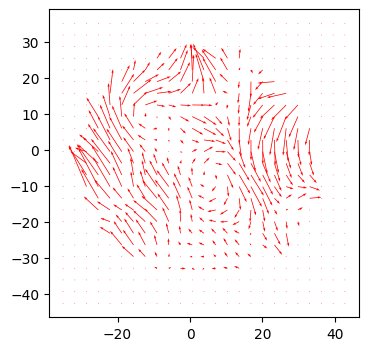

1


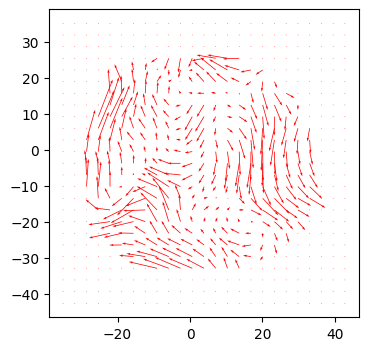

2


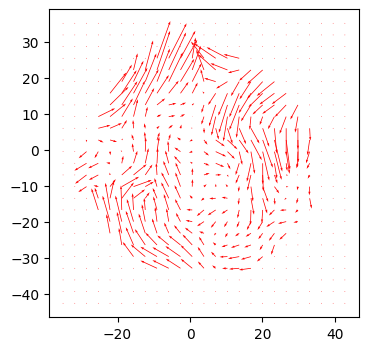

3


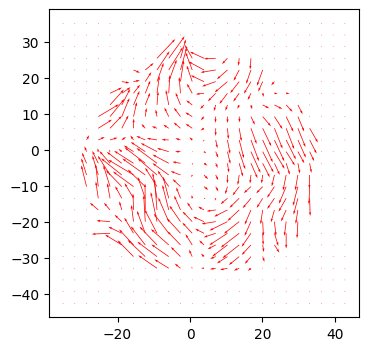

4


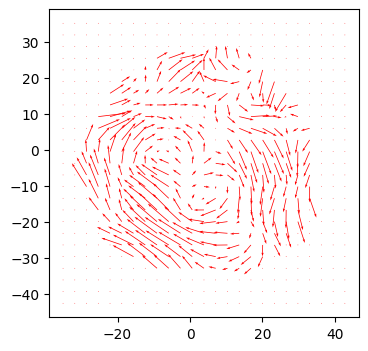

5


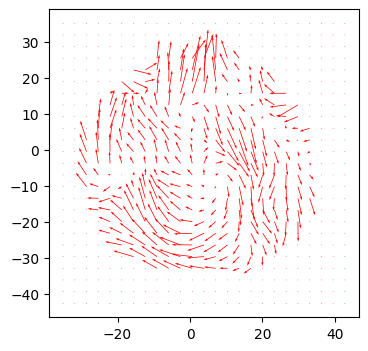

6


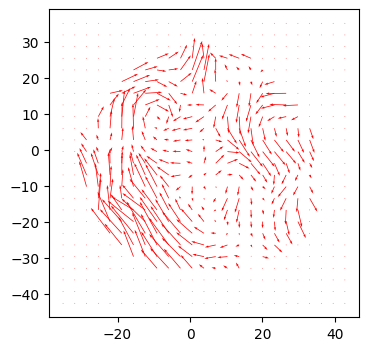

7


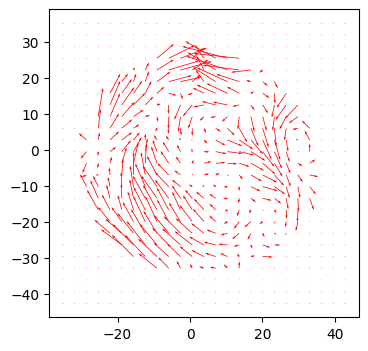

8


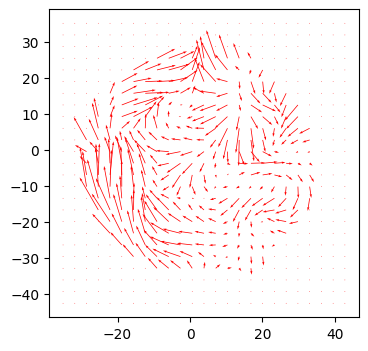

9


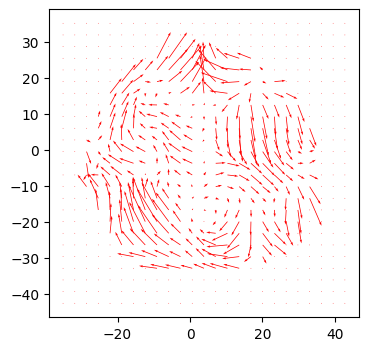

10


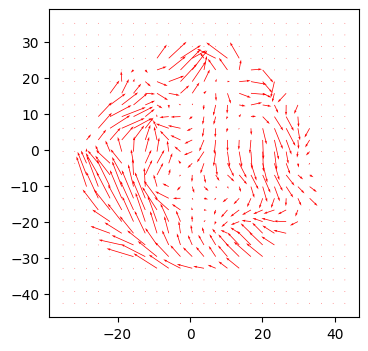

11


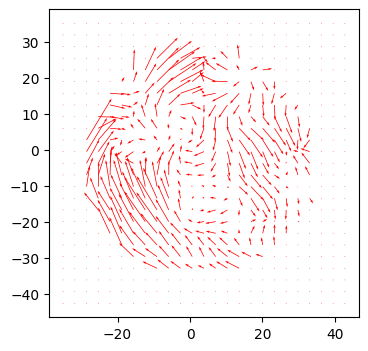

12


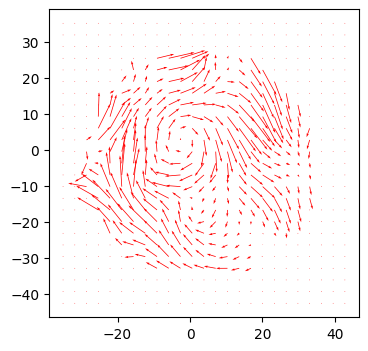

13


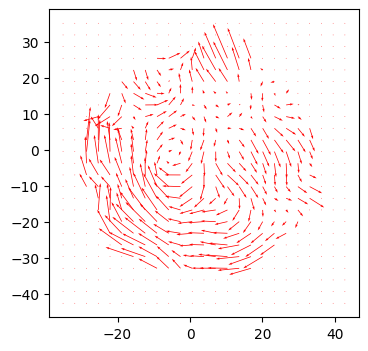

14


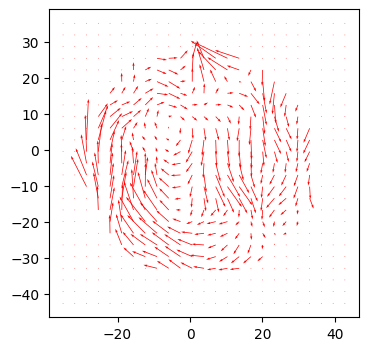

15


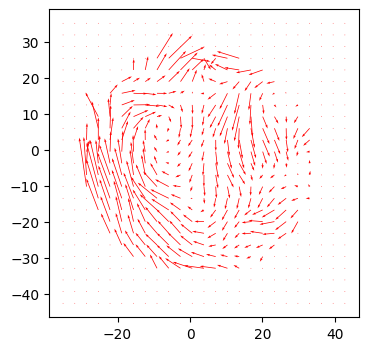

16


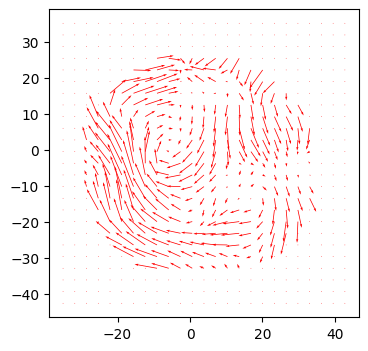

17


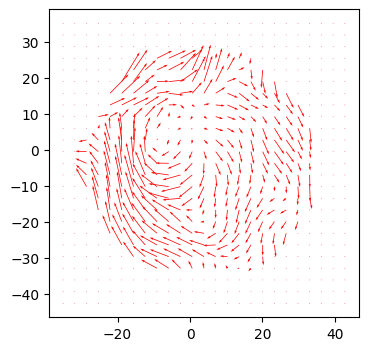

18


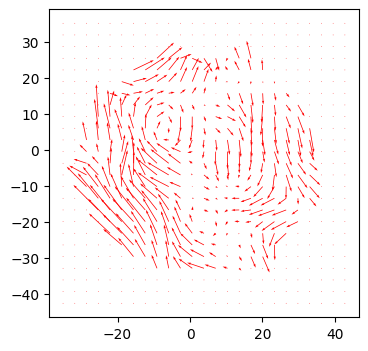

19


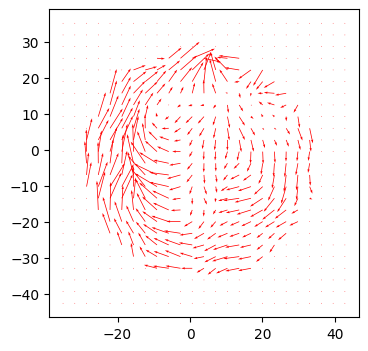

20


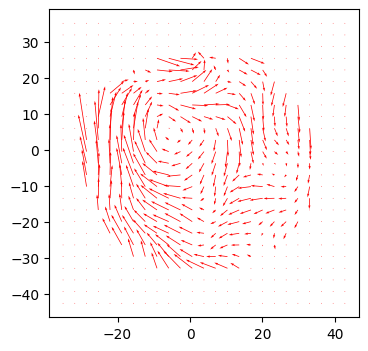

21


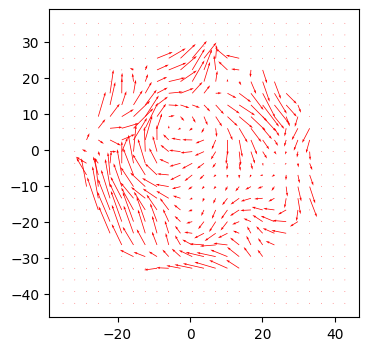

22


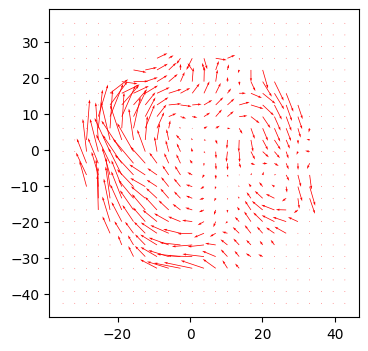

23


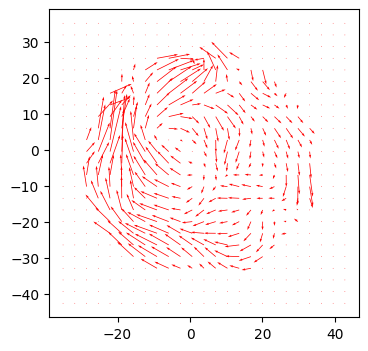

24


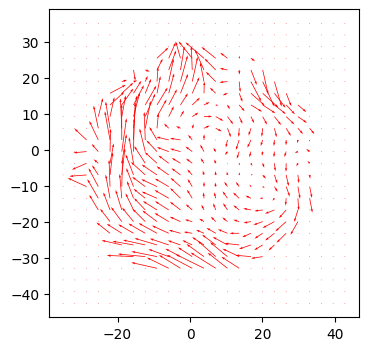

25


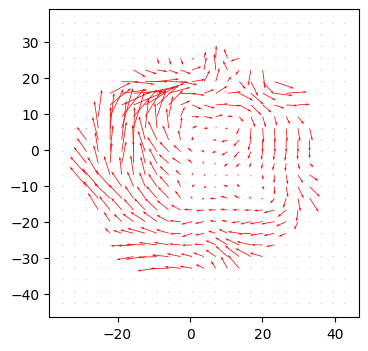

26


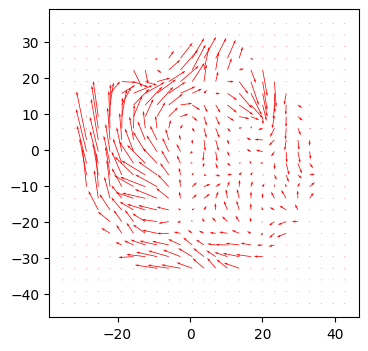

27


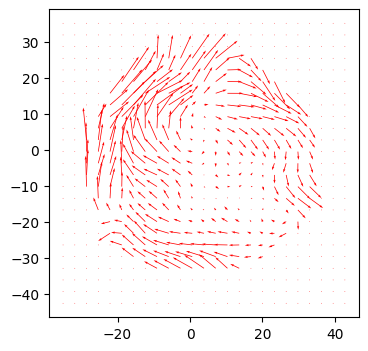

28


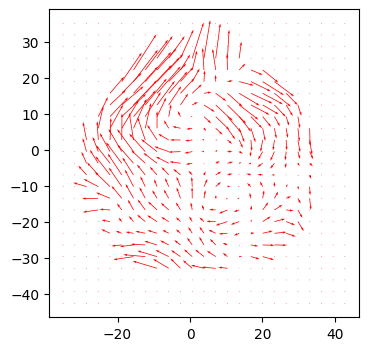

29


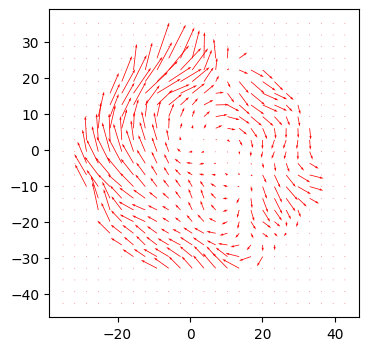

30


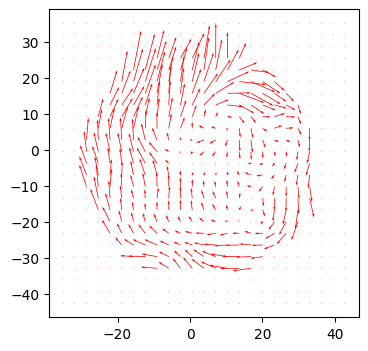

31


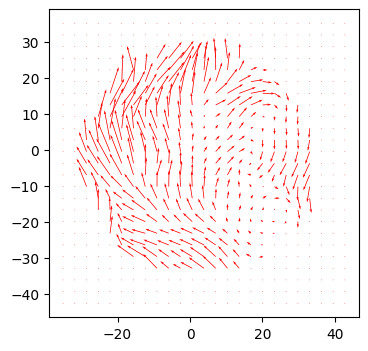

32


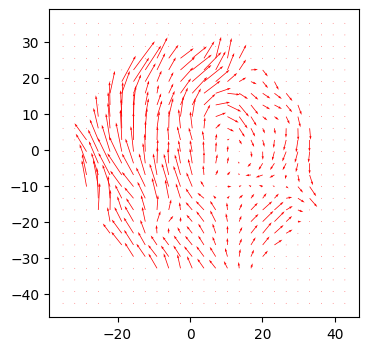

33


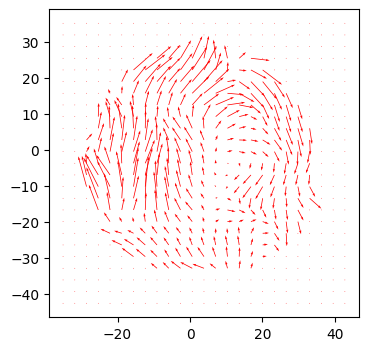

34


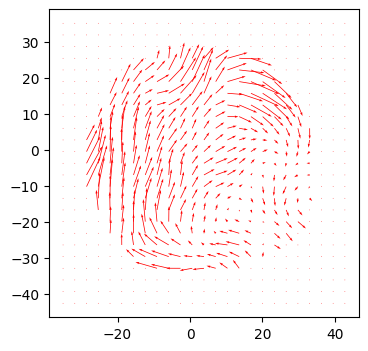

35


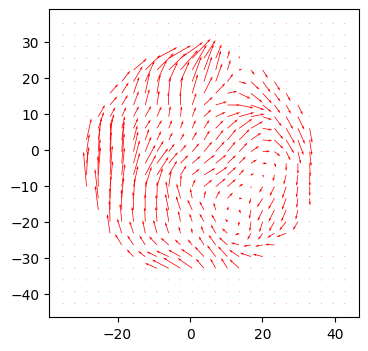

36


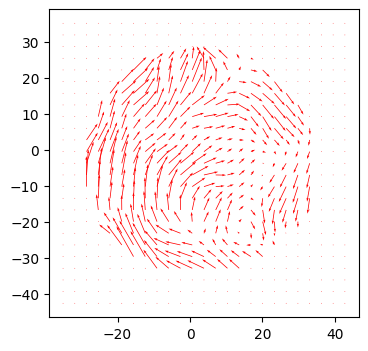

37


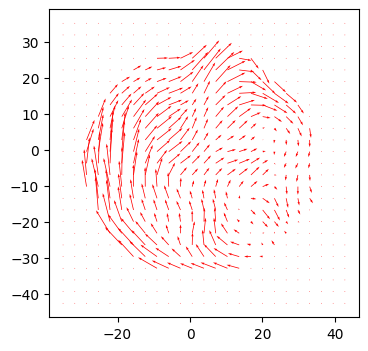

38


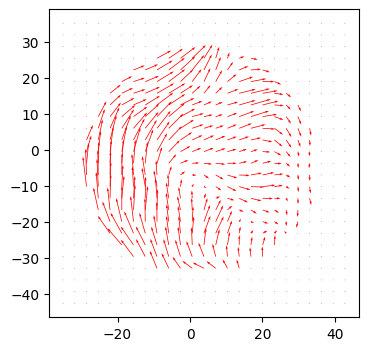

39


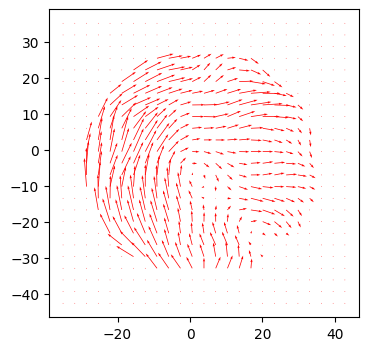

In [9]:
for i in range(40):
    print(i)
    plt.figure(figsize=(4,4))

    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],u_train[:,:,i,0],u_train[:,:,i,1],color='r')

    plt.show()

In [10]:
# Define PDE library that is quadratic in u, and
# fourth-order in spatial derivatives of u.
library_functions = [
    lambda y: y,
    lambda x: x * x * x,

    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda y: y,
    lambda x: x + x + x,

    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    periodic=True
)


# Again, loop through all the optimizers
#print('STLSQ model: ')
print('u_train')
print(u_train.shape)

'''
print('SINDy')
model = ps.SINDy(feature_names=['Vx','Vy'])

model.fit(u_train, x_dot=u_dot_train)
model.print()
u_dot_stlsq = model.predict(u_train)

'''
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5, 
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])
model.fit(u_train, dt)
model.print()


u_train
(25, 25, 40, 2)
STLSQ model: 
(Vx)' = 878.959 1 + 2072.544 Vx + -371.175 Vy + -105.641 VxVxVx + -1.695 VyVyVy + -54.863 VxVyVy + 42.325 VxVxVy + 3867.295 Vx_2 + 5495.962 Vy_2 + 8933.333 Vx_22 + -1298.119 Vy_22 + 1496.947 Vx_222 + -1461.804 Vy_222 + -5545.040 Vx_1 + -1044.765 Vy_1 + 19368.093 Vx_12 + 12212.556 Vy_12 + -42928.118 Vx_122 + 14187.431 Vy_122 + 6264.394 Vx_11 + 1858.477 Vy_11 + 12111.480 Vx_112 + 13146.063 Vy_112 + 3502.285 Vx_111 + 2024.601 Vy_111 + -6207.447 VxVx_2 + 3229.773 VxVy_2 + -43.443 VyVx_2 + -65.527 VyVy_2 + 108.787 VxVxVxVx_2 + -78.356 VxVxVxVy_2 + -3157.674 VyVyVyVx_2 + -2039.922 VyVyVyVy_2 + -126.019 VxVyVyVx_2 + 50.795 VxVyVyVy_2 + 82.612 VxVxVyVx_2 + -175.612 VxVxVyVy_2 + -2479.969 VxVx_22 + -1490.656 VxVy_22 + 70.383 VyVx_22 + -57.111 VyVy_22 + 134.523 VxVxVxVx_22 + -277.913 VxVxVxVy_22 + -9634.759 VyVyVyVx_22 + 1475.354 VyVyVyVy_22 + 304.453 VxVyVyVx_22 + 5.769 VxVyVyVy_22 + 119.821 VxVxVyVx_22 + 137.694 VxVxVyVy_22 + -38388.035 VxVx_222 + 36094.23

In [11]:
print("Model score: %f" % model.score(u_train, t=dt))

Model score: 0.041250


In [12]:
# Predict derivatives using the learned model

x_dot_test_predicted = model.predict(u_train)
x_dot_test_computed = model.differentiate(u_train, t=dt)

testscore(x_test_sim,x_dot_test_computed)

NameError: name 'x_test_sim' is not defined

In [ ]:
# integrate by self
dot_tmp=np.array(x_dot_test_predicted)
pltpredict=np.zeros((n,n,40,2))
pltpredict[:,:,0,:]=u_train[:,:,0,:]
for i in range(39):
    pltpredict[:,:,i+1]=pltpredict[:,:,i]+dot_tmp[:,:,i]*dt
testscore(pltpredict,save)

In [ ]:
for i in range(40):
    print(i)
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],u_train[:,:,i,0],u_train[:,:,i,1],color='r')
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.subplot(1, 3, 2)
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],u_train[:,:,i,0],u_train[:,:,i,1],color='r')
    #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.subplot(1, 3, 3)
    #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.show()
    print('score')
    print(testscore(pltpredict[:,:,i,],save[:,:,i,:]))

In [ ]:
#predict step by step
pltpredict=u_train+dot_tmp*dt
pltpredict[:,:,1:]=pltpredict[:,:,:len(t)-1]
testscore(pltpredict,save)
'-1.07'

In [ ]:
for i in range(40):
    print(i)
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],u_train[:,:,i,0],u_train[:,:,i,1],color='r')
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.subplot(1, 3, 2)
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],u_train[:,:,i,0],u_train[:,:,i,1],color='r')
    #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.subplot(1, 3, 3)
    #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.show()
    print('score')
    testscore(pltpredict[:,:,i,],save[:,:,i,:])